In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
# Modified from bsv_crossing.m
# bsv_crossing() estimates the location X0 where U(X0) = 0.
# 
#   Discussion:
# 
#   This function is intended for a special case, in which we are solving
#   the Burgers equation over an interval [A,B], with positive boundary
#   condition at one end and negative at the other.  In that case, the
#   solution must change be zero at some point X0 in the interval.
# 
#   We assume the solution is discretized by a piecewise linear function.
#   We use binary search to locate consecutive indices I and I+1 so that
#   U(I) and U(I+1) are of opposite signs.  We use linear interpolation to
#   estimate the location of X0 between X(I) and X(I+1).
def bsv_crossing(a, b, n, x, u):
    if (u[0] == 0):
        x0 = x[0]
    elif (u[n-1] == 0):
        x0 = x[n-1]
    else:
        if (u[0]*u[n-1] > 0):
            print('BSV_CROSSING - Fatal error!')
            print('We require opposite signs for U(1) and U(N)')
            raise Exception('BSV_CROSSING - Fatal error!')
        i = 0
        k = n-1

        while (k - i > 1): 
            j = int(np.floor((k+i)/2))
            if (u[j] == 0):
                x0 = x[j]
                return x0
            else:
                if (u[i]*u[j] > 0):
                    i = j
                else:
                    k = j
        x0 = (u[i]*x[k]-u[k]*x[i])/(u[i] - u[k])
    return x0

In [3]:
def burgers_steady_viscous (a, b, alpha, beta, nu, n, output):
# burgers_steady_viscous() applies Newton's method to a discretized steady viscous Burgers equation.
## Input:
##
## real A, B, the left and right endpoints.
#
## real ALPHA, BETA, the Dirichlet boundary values at the left and right.
##
## real NU, the viscosity.  Normally, 0 < NU.
##
## integer N, the number of nodes to use between A and B.
##
## logical OUTPUT, is TRUE if printout is desired.
##
## Output:
##
##  real U(N), the computed discretized solution.
    if (n < 2): 
        print('BURGERS_STEADY_VISCOUS - Fatal error!' )
        print('N < 2.' )
        Exception( 'BURGERS_STEADY_VISCOUS - Fatal error!' )
    
    # Set some iteration parameters.
    eps = 2.2204e-16 # from Matlab
    newton_step_max = 5000
    newton_resid_tol = np.sqrt(eps)
    newton_step_tol = np.sqrt(eps)

    # Use equally spaced nodes from A to B.
    dx = (b-a)/(n-1) # There are n points, the endpoints are a, b
    u = np.linspace(alpha, beta, n) # initialize u to an n-valued array with bounds (alpha, beta)
    u = u.reshape(-1,1)
    # Prepare for the Newton iteration.
    J = np.zeros([n, n]) # Initialize the Jacobi matrix
    f = np.zeros([n, 1]) # Initialize the residual f
    newton_step = 0

    if (output):
        print(" Step ||f(u)||")
    
    while (newton_step <= newton_step_max):
        # Compute the residual f
        f[0] = u[0] - alpha # The residual at the boundary point a
        
        # Compute the residuals of f at u(0), ... , u(n-2)
        f[1:n-1] = 0.5 * ( u[2:n]**2 - u[0:n-2]**2 ) / ( 2.0 * dx ) - nu * ( u[2:n] - 2*u[1:n-1] + u[0:n-2] ) / ( dx**2 )
        
        f[n-1] = u[n-1] - beta # residual at boundary point b

        f_norm = linalg.norm(f, np.inf)
        
        if (output):
            print(newton_step, f_norm)

        if (f_norm < newton_resid_tol): # If the residual is small enough, exit the loop
            break
        
        # Define the Jacobian matrix.
        J[0,0] = 1.0; # The derivative of f(0) to u(0) is f(0) = u(0) - alpha, and the derivatives of f(0) to u(1), ... , u(n-1) are all is 0

        for i in range(1, n-1):
            J[i,i-1] = - 2.0 * u[i-1] / ( 4.0 * dx )       - nu / dx**2 # Computes the derivative of f(i) with respect to u(i-1) (1 <= i <= n-2)
            J[i,i]   =                                 2.0 * nu / dx**2 # Computes the derivative of f(i) with respect to u(i) (1 <= i <= n-2)
            J[i,i+1] =   2.0 * u[i+1] / ( 4.0 * dx )       - nu / dx**2 # Computes the derivative of f(i) with respect to u(i+1) (1 <= i <= n-2)
        
        J[n-1,n-1] = 1.0 # The derivative of f(n-1) with respect to u(n-1), since f(n-1) = u(n-1) - beta, 
        # and f(n-1) with respect to u(0), ... , the derivatives of u(n-2) are all 0
        
        # Solve the linear system J * du = f to get the Newton update. (J * du = -f in the Matlab version code, seems to be typo)
        du = linalg.solve(J, f)

        du_norm = linalg.norm(du, np.inf)

        u_norm = linalg.norm(u, np.inf)
        if (du_norm < newton_step_tol * (u_norm + 1.0)):
            break
        
        u = u - du
        # if (newton_step == 0): print(u)
        newton_step = newton_step + 1
        
        if (newton_step_max < newton_step):
            print('BURGERS_STEADY_VISCOUS - Warning!' )
            print('The Newton iteration did not converge.' )
        
    return u

In [4]:
def burgers_upwind(a, b, alpha, beta, nu, n, output):
# burgers_upwind() applies Newton's method to a discretized steady viscous Burgers equation.
## Discussion:
#   An upwind scheme is used to combat the numerical oscillations that
#   can occur otherwise.
#
## Input:
##
## real A, B, the left and right endpoints.
#
## real ALPHA, BETA, the Dirichlet boundary values at the left and right.
##
## real NU, the viscosity.  Normally, 0 < NU.
##
## integer N, the number of nodes to use between A and B.
##
## logical OUTPUT, is TRUE if printout is desired.
##
## Output:
##
##  real U(N), the computed discretized solution.
    if (n < 2): 
        print('BURGERS_UPWIND - Fatal error!' )
        print('N < 2.' )
        Exception( 'BURGERS_UPWIND - Fatal error!' )
    
    # Set some iteration parameters.
    eps = 2.2204e-16 # from Matlab
    newton_step_max = 5000
    newton_resid_tol = np.sqrt(eps)
    newton_step_tol = np.sqrt(eps)

    # Use equally spaced nodes from A to B.
    dx = (b-a)/(n-1) # There are n points, the endpoints are a, b
    u = np.linspace(alpha, beta, n) # initialize u to an n-valued array with bounds (alpha, beta)
    u = u.reshape(-1,1)
    # Prepare for the Newton iteration.
    J = np.zeros([n, n]) # Initialize the Jacobi matrix
    f = np.zeros([n, 1]) # Initialize the residual f
    newton_step = 0

    if (output):
        print(" Step ||f(u)||")
    
    while (newton_step <= newton_step_max):
        # Compute the residual f
        f[0] = u[0] - alpha # The residual at the boundary point a
        
        # Compute the residuals of f at u(0), ... , u(n-2)
        f[1:n-1] = -nu * (u[2:n] - 2.0*u[1:n-1] + u[0:n-2])  / (dx**2)      

        i = np.argwhere(u[1:n-1] >= 0)[:,0]
        i = i + 1 # Because np.argwhere returns the index that satisfies the condition in u[1:n-1], 
        # so if you want to index in the original array u, you need to +1 the returned index i

        j = np.argwhere(u[1:n-1] <  0)[:,0]
        j = j + 1

        f[i] = f[i] + 0.5 * (u[i]**2   - u[i-1]**2) / dx
        f[j] = f[j] + 0.5 * (u[j+1]**2 - u[j]**2  ) / dx

        f[n-1] = u[n-1] - beta # residual at boundary point b

        f_norm = linalg.norm(f, np.inf)
        
        if (output):
            print(newton_step, f_norm)

        if (f_norm < newton_resid_tol): # If the residual is small enough, exit the loop
            break
        
        # Define the Jacobian matrix.
        J[0,0] = 1.0; # The derivative of f(0) to u(0) is f(0) = u(0) - alpha, and the derivatives of f(0) to u(1), ... , u(n-1) are all is 0

        for i in range(1, n-1):
            if ( 0.0 <= u[i] ):
                J[i,i-1] = -u[i-1] / dx       - nu / dx**2 # Computes the derivative of f(i) with respect to u(i-1) (1 <= i <= n-2)
                J[i,i]   =  u[i]   / dx + 2.0 * nu / dx**2 # Computes the derivative of f(i) with respect to u(i) (1 <= i <= n-2)
                J[i,i+1] =                    - nu / dx**2 # Computes the derivative of f(i) with respect to u(i+1) (1 <= i <= n-2)
            else:
                J[i,i-1] =                    - nu / dx**2 # Computes the derivative of f(i) with respect to u(i-1) (1 <= i <= n-2)
                J[i,i]   = -u[i]   / dx + 2.0 * nu / dx**2 # Computes the derivative of f(i) with respect to u(i) (1 <= i <= n-2)
                J[i,i+1] =  u[i+1] / dx       - nu / dx**2 # Computes the derivative of f(i) with respect to u(i+1) (1 <= i <= n-2)

        J[n-1,n-1] = 1.0 # The derivative of f(n-1) with respect to u(n-1), since f(n-1) = u(n-1) - beta, 
        # and f(n-1) with respect to u(0), ... , the derivatives of u(n-2) are all 0
        
        # Solve the linear system J * du = f to get the Newton update. (J * du = -f in the Matlab version code, seems to be typo)
        du = linalg.solve(J, f)

        du_norm = linalg.norm(du, np.inf)

        u_norm = linalg.norm(u, np.inf)
        if (du_norm < newton_step_tol * (u_norm + 1.0)):
            break
        
        u = u - du
        # if (newton_step == 0): print(u)
        newton_step = newton_step + 1
        
        if (newton_step_max < newton_step):
            print('BURGERS_UPWIND - Warning!' )
            print('The Newton iteration did not converge.' )
        
    return u

### Test case 1

In [5]:
a = -1.0
b = +1.0
alpha = 1.0
beta = -1.0
nu = 0.1
n = 21
output = 1

u = burgers_steady_viscous ( a, b, alpha, beta, nu, n, output)

 Step ||f(u)||
0 0.8999999999999997
1 1.317700803255531
2 0.14034535680204263
3 0.0015858198245161659
4 1.5864451391456313e-07


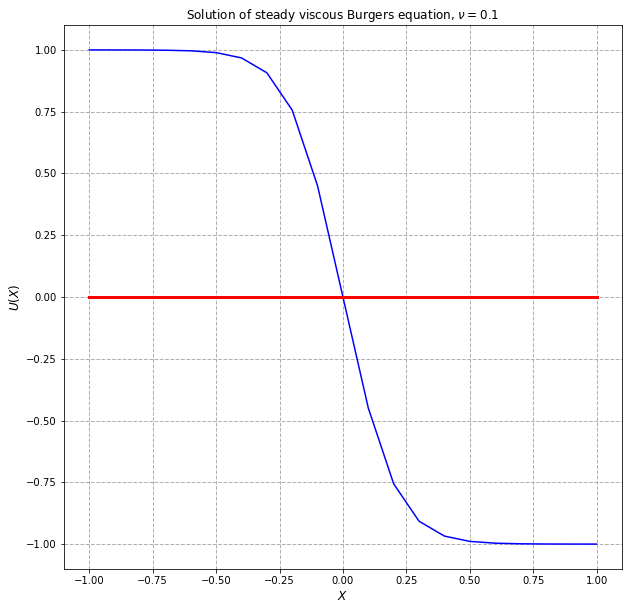

In [6]:
# Plot the solution
xx = np.linspace(a, b, n)

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(xx, u, 'b-')
ax.plot([a,b], [0.0, 0.0], 'r-', linewidth=3)
ax.set_title ( 'Solution of steady viscous Burgers equation, $\\nu = 0.1$')
ax.set_xlabel ('$X$', fontsize=12)
ax.set_ylabel ('$U(X)$', fontsize=12)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(1.1*beta, 1.1*alpha)

ax.grid(linestyle='--', linewidth=1)
plt.savefig('py_bsv_test01.png')
plt.show()

In [7]:
# Get the point x0 where u(x0) = 0
x0 = bsv_crossing ( a, b, n, xx, u )
print('U(X0) = 0 estimated at X0 = ', x0)

U(X0) = 0 estimated at X0 =  [3.91213951e-14]


### Test case 2
 Solution of steady viscous Burgers equation, consider a variety of values of viscosity nu.

In [8]:
a = -1.0
b = +1.0
alpha = 1.0
beta = -1.0
nu_test = [ 0.8, 0.4, 0.2, 0.1, 0.05, 0.025 ]
test_num = len(nu_test)
n = 400
output = 0

u = np.zeros([n,test_num])

for test, nu in enumerate(nu_test):
    print ('Using NU = ', nu)
    u[:,test] = burgers_steady_viscous ( a, b, alpha, beta, nu, n, output).reshape(-1)


Using NU =  0.8
Using NU =  0.4
Using NU =  0.2
Using NU =  0.1
Using NU =  0.05


C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=1.06977e-16): result may not be accurate.
  du = linalg.solve(J, f)


Using NU =  0.025


C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=3.97041e-21): result may not be accurate.
  du = linalg.solve(J, f)
C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=1.78828e-21): result may not be accurate.
  du = linalg.solve(J, f)
C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=3.563e-20): result may not be accurate.
  du = linalg.solve(J, f)
C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=3.48314e-22): result may not be accurate.
  du = linalg.solve(J, f)
C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=1.19855e-21): result may not be accurate.
  du = linalg.solve(J, f)
C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditione

ValueError: array must not contain infs or NaNs

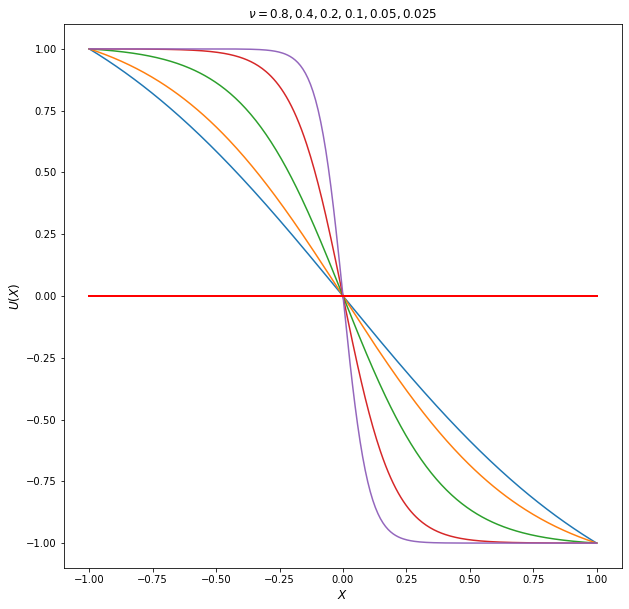

In [9]:
xx = np.linspace(a, b, n)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(xx, u)
ax.plot( [a,b], [0.0,0.0], 'r-', linewidth=2 )
ax.set_xlabel ('$X$', fontsize=12)
ax.set_ylabel ('$U(X)$', fontsize=12)
ax.set_ylim(1.1*beta, 1.1*alpha)
ax.set_title('$\\nu = 0.8, 0.4, 0.2, 0.1, 0.05, 0.025$')
plt.savefig('py_bsv_test02.png')
plt.show()

### Test case 3
Varies the left boundary value ALPHA in the Burgers equation.

In [10]:
a = -1.0
b = +1.0
alpha_test = [ 0.96, 0.98, 0.99, 0.995, 1.0, 1.005, 1.010, 1.02, 1.04 ]
beta = -1.0
nu = 0.1
test_num = len(alpha_test)
n = 161
output = 0

u = np.zeros([n,test_num])

for test, alpha in enumerate(alpha_test):
    print('Using ALPHA = ', alpha)
    u[:,test] = burgers_steady_viscous ( a, b, alpha, beta, nu, n, output ).reshape(-1)


Using ALPHA =  0.96
Using ALPHA =  0.98
Using ALPHA =  0.99
Using ALPHA =  0.995
Using ALPHA =  1.0
Using ALPHA =  1.005
Using ALPHA =  1.01
Using ALPHA =  1.02
Using ALPHA =  1.04


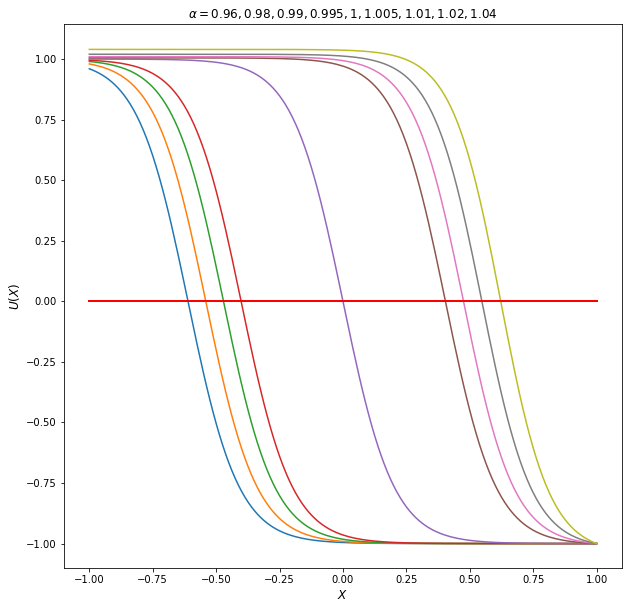

In [11]:
xx = np.linspace(a, b, n)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(xx, u)
ax.plot( [a,b], [0.0,0.0], 'r-', linewidth=2 )
ax.set_xlabel ('$X$', fontsize=12)
ax.set_ylabel ('$U(X)$', fontsize=12)
ax.set_ylim(1.1*beta, 1.1*alpha)
ax.set_title('$\\alpha = 0.96, 0.98, 0.99, 0.995, 1, 1.005, 1.01, 1.02, 1.04$')
plt.savefig('py_bsv_test03.png')
plt.show()

### Test case 4
Varies the location of the left boundary A in the Burgers equation.

In [12]:
a_test = [ -1.04, -1.02, -1.01, -1.005, -1.0, -0.995, -0.99, -0.98, -0.96 ]
test_num = len(a_test)
b = +1.0
alpha = 1.0
beta = -1.0
nu = 0.1
n = 161
output = 0

u = np.zeros([n, test_num])

for test, a in enumerate(a_test):
    print('Using A = ', a)
    u[:,test] = burgers_steady_viscous ( a, b, alpha, beta, nu, n, output ).reshape(-1)

Using A =  -1.04
Using A =  -1.02
Using A =  -1.01
Using A =  -1.005
Using A =  -1.0
Using A =  -0.995
Using A =  -0.99
Using A =  -0.98
Using A =  -0.96


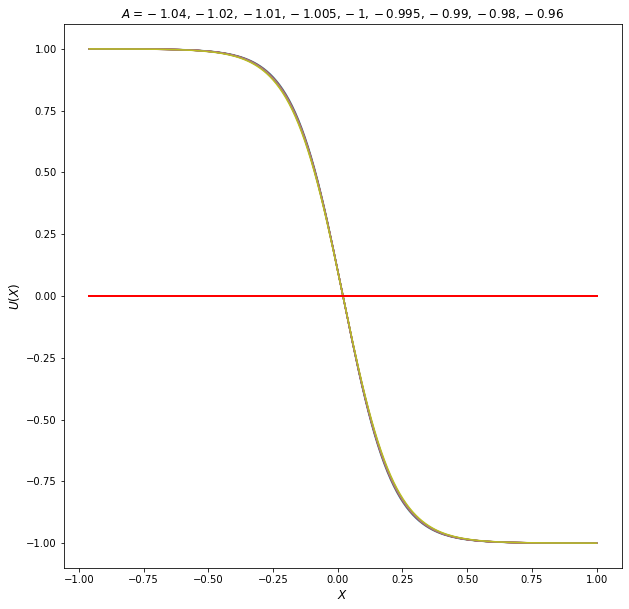

In [13]:
xx = np.linspace(a, b, n)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(xx, u)
ax.plot( [a,b], [0.0,0.0], 'r-', linewidth=2 )
ax.set_xlabel ('$X$', fontsize=12)
ax.set_ylabel ('$U(X)$', fontsize=12)
ax.set_ylim(1.1*beta, 1.1*alpha)
ax.set_title('$A = -1.04, -1.02, -1.01, -1.005, -1, -0.995, -0.99, -0.98, -0.96$')
plt.savefig('py_bsv_test04.png')
plt.show()

### Test case 5
Computes the zero crossing as a function of the left boundary value.

In [14]:
a = -1.0
b = +1.0
beta = -1.0
nu = 0.1
n = 81
output = 0

xx = np.linspace(a, b, n)

m = 21
alpha_min = 0.95
alpha_max = 1.05
alpha_vec = np.linspace(alpha_min, alpha_max, m)

alpha_ave = 0.5 * ( alpha_vec[0] + alpha_vec[m-1] )

alpha_vec = alpha_ave + np.sign( alpha_vec - alpha_ave ) * ( ( alpha_vec - alpha_ave ) / ( alpha_max - alpha_ave ) ) ** 2 * ( alpha_max - alpha_ave )

x0_vec = np.zeros([m,1])

for i in range(0, m):
    alpha = alpha_vec[i]
    u = burgers_steady_viscous ( a, b, alpha, beta, nu, n, output )
    x0_vec[i] = bsv_crossing ( a, b, n, xx, u )

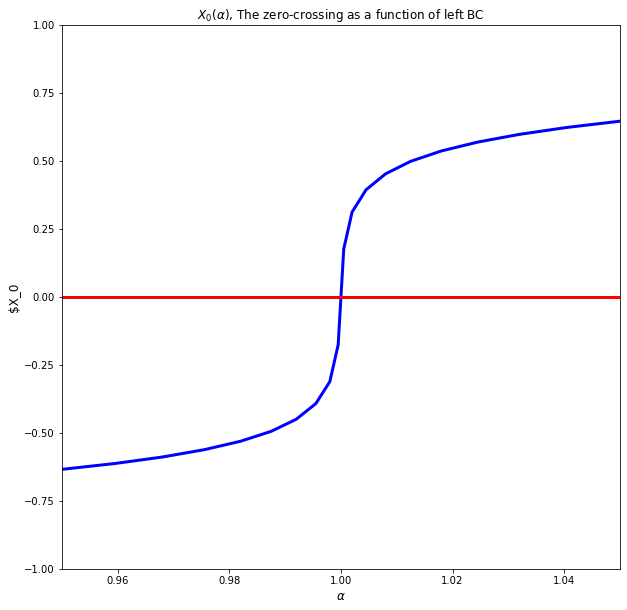

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha_vec, x0_vec, 'b-', linewidth=3 )
ax.plot([ alpha_min, alpha_max ], [ 0.0, 0.0 ], 'r-', linewidth=3)
ax.set_title ('$X_0(\\alpha)$, The zero-crossing as a function of left BC' )
ax.set_xlabel ( '$\\alpha$', fontsize=12 )
ax.set_ylabel ( '$X_0', fontsize=12)
ax.set_xlim( [alpha_min, alpha_max])
ax.set_ylim([-1.0, +1.0])
plt.savefig('py_bsv_test05.png')
plt.show()

### Test case 6
Estimating the expected value of the zero crossing.

Discussion:

We assume that the left boundary condition ALPHA can vary like
a Gaussian variable with mean 1 and standard deviation 0.05.

Estimate the integral:
$$
    E(X_0(\alpha)) = \int_{-\infty}^{+\infty} x_0(\alpha) f(\alpha) \mathrm{d} \alpha,
$$
where
$$
f(\alpha) = \frac{1}{ \sigma \sqrt{ 2 \pi} } \mathrm{e}^{ -\frac{1}{2} (\frac{\alpha - \mu}{ \sigma})^2}.
$$

In [16]:
a = -1.0
b = +1.0
beta = -1.0
nu = 0.1
n = 81
output = 0

xx = np.linspace(a, b, n)

In [20]:
#  Monte Carlo Estimate.
#  Choose M normal random samples with the correct STD, 
#  find X0 for each, and average.

print('M    E(X0(ALPHA)) estimate')

mu = 1.0
sigma = 0.05
for j in range(4, 11):
    m = 2**j
    alpha_vec = mu + 0.05 * np.random.randn(m, 1)
    x0_bar = 0.0
    
    for i in range(0, m):
        alpha = alpha_vec[i]
        output = 0
        u = burgers_steady_viscous(a, b, alpha, beta, nu, n, output)
        x0 = bsv_crossing(a, b, n, xx, u)
        x0_bar = x0_bar + x0
    
    x0_bar = x0_bar / m
    
    print(m, x0_bar)

M    E(X0(ALPHA)) estimate
16 [-0.08385772]
32 [-0.04477497]
64 [0.03071938]
128 [0.01932738]
256 [-0.03843063]
512 [0.00721046]
1024 [-0.0075559]


### Test case 7
Estimating the variance of the zero crossing.
We assume that the left boundary condition ALPHA can vary like

A Gaussian variable with mean 1 and standard deviation 0.05.
Estimate the integral:
$$
      \mathrm{Var} (X_0(\alpha)) = \int_{-\infty}^{+\infty} x_0^2 (\alpha) f(\alpha) \mathrm{d} \alpha,
$$
where
$$
f(\alpha) = \frac{1}{ \sigma \sqrt{ 2 \pi} } \mathrm{e}^{ -\frac{1}{2} (\frac{\alpha - \mu}{ \sigma})^2}.
$$


In [21]:
a = -1.0
b = +1.0
beta = -1.0
nu = 0.1
n = 81
output = 0

xx = np.linspace(a, b, n)

In [22]:
#  Monte Carlo Estimate.
#  Choose M normal random samples with the correct STD, 
#  find X0 for each, and average.

print('M    Var(X0(ALPHA)) estimate')

mu = 1.0
sigma = 0.05
for j in range(4, 11):
    m = 2**j
    alpha_vec = mu + 0.05 * np.random.randn(m, 1)
    x0_bar = 0.0
    
    for i in range(0, m):
        alpha = alpha_vec[i]
        output = 0
        u = burgers_steady_viscous(a, b, alpha, beta, nu, n, output)
        x0 = bsv_crossing(a, b, n, xx, u)
        x0_bar = x0_bar + x0**2
    
    x0_bar = x0_bar / m
    
    print(m, x0_bar)

M    Var(X0(ALPHA)) estimate
16 [0.35861204]
32 [0.34342473]
64 [0.33589398]
128 [0.35167934]
256 [0.34328865]
512 [0.34204693]
1024 [0.34460785]


### Test case 8
Compare BSV and BSV_UPWIND.

Upwinding is a scheme which reduces the numerical oscillations that can occur as the viscosity in the Burgers equation is decreased.

The distortion caused by upwinding is visible for N = 21, NU = 0.1.

In [23]:
a = -1.0
b = +1.0
alpha = 1.0
beta = -1.0
nu = 0.1
n = 21
output = 0

In [24]:
nu = 0.1
u1 = np.zeros([n, 2])
u1[:, 0] = burgers_steady_viscous(a, b, alpha, beta, nu, n, output).reshape(-1)
u1[:, 1] = burgers_upwind(a, b, alpha, beta, nu, n, output).reshape(-1)

In [25]:
# NU = 0.01
nu = 0.01
u2 = np.zeros([n, 2])
u2[:, 0] = burgers_steady_viscous(a, b, alpha, beta, nu, n, output).reshape(-1)
u2[:, 1] = burgers_upwind(a, b, alpha, beta, nu, n, output).reshape(-1)

C:\Users\zhufa\AppData\Local\Temp\ipykernel_26460\2483745049.py:70: LinAlgWarning: Ill-conditioned matrix (rcond=6.83376e-19): result may not be accurate.
  du = linalg.solve(J, f)


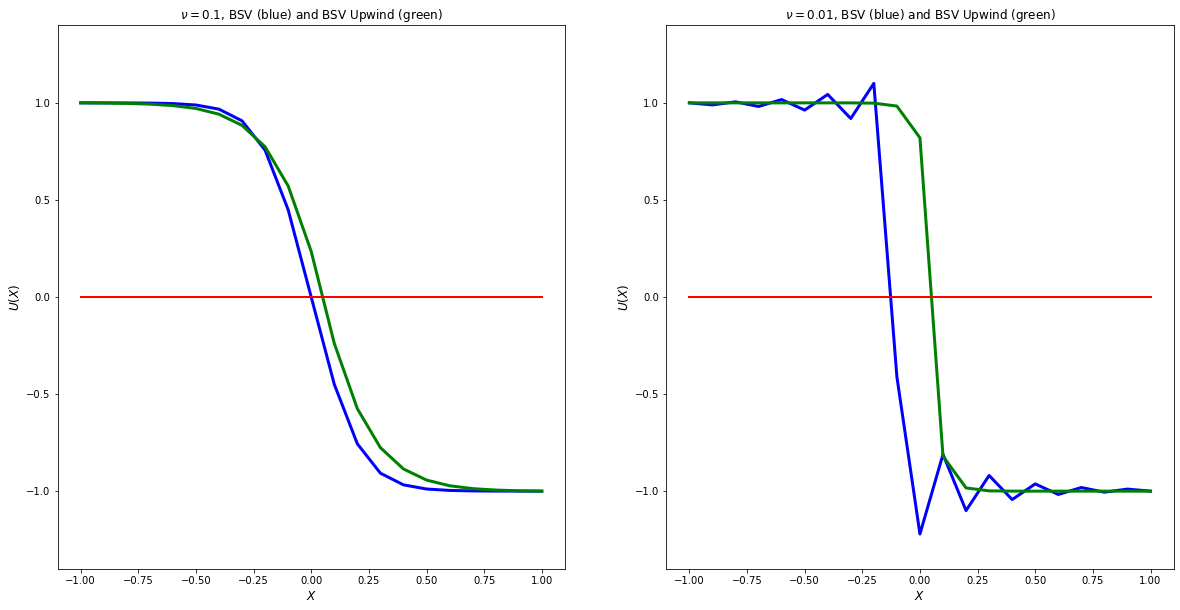

In [27]:
xx = np.linspace(a, b, n)

fig, ax = plt.subplots(1,2, figsize = (20,10))
ax[0].plot(xx, u1[:, 0], 'b-', linewidth=3)
ax[0].plot(xx, u1[:, 1], 'g-', linewidth=3)
ax[0].plot( [a,b], [0.0,0.0], 'r-', linewidth=2 )
ax[0].set_xlabel ('$X$', fontsize=12)
ax[0].set_ylabel ('$U(X)$', fontsize=12)
ax[0].set_ylim(1.4*beta, 1.4*alpha)
ax[0].set_title('$\\nu = 0.1$, BSV (blue) and BSV Upwind (green)')

ax[1].plot(xx, u2[:, 0], 'b-', linewidth=3)
ax[1].plot(xx, u2[:, 1], 'g-', linewidth=3)
ax[1].plot( [a,b], [0.0,0.0], 'r-', linewidth=2 )
ax[1].set_xlabel ('$X$', fontsize=12)
ax[1].set_ylabel ('$U(X)$', fontsize=12)
ax[1].set_ylim(1.4*beta, 1.4*alpha)
ax[1].set_title('$\\nu = 0.01$, BSV (blue) and BSV Upwind (green)')
plt.savefig('py_bsv_test08.png')
plt.show()